# Spectrum Slicing Test Suite Demo

We will demo the spectrum slicing test suite by generating test problems from a given matrix and visualizing the expected performance of two different rational filters in FEAST.


First we load the `SpectrumSlicingTestSuite` and other required modules:

In [1]:
import SpectrumSlicingTestSuite
import MatrixDepot
import BenchmarkProfiles
using Measures
using LinearAlgebra
using Plots

┌ Info: Precompiling SpectrumSlicingTestSuite [9d626e9e-037c-4cf1-92ae-c6e6dcb749aa]
└ @ Base loading.jl:1342


include group.jl for user defined matrix generators
verify download of index files...
reading database
adding metadata...
adding svd data...
writing database
used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


## The rational filters

We use rational filter functions taken from [here](https://arxiv.org/abs/1704.03255)

In [2]:
zGauss = [
 -0.998055+0.0623361im
 -0.949425+0.313993im 
 -0.73489+0.678186im 
 -0.284168+0.958775im 
];
aGauss = [
 0.0252579-0.00157755im
 0.0527835-0.0174565im 
 0.057635-0.0531879im 
 0.0257658-0.086933im  
];

zSLiSe = [
 -0.999716+0.0100714im
 -0.985299+0.0834839im
 -0.890636+0.30265im  
 -0.435696+0.697878im 
];
aSLiSe = [
  0.00522242-0.000328736im
  0.0197875-0.00532048im 
  0.0532178-0.0321933im  
  0.0536992-0.121132im   
];


Now, we plot the two functions on the interval `[-1,1]`

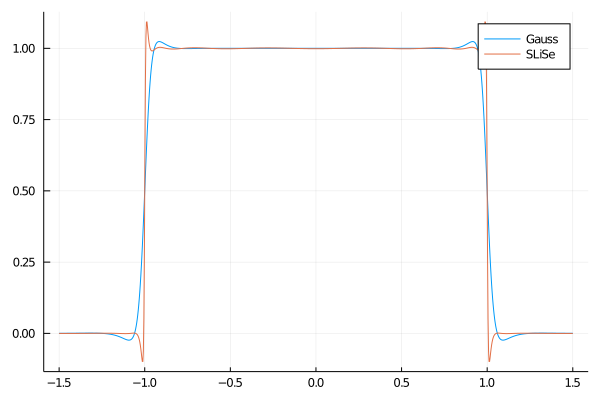

In [3]:
x = range(-1.5, 1.5, length=1001)
f = function(z,a) SpectrumSlicingTestSuite.phi(z,a,[-1,1],x) |> real end
plot(x, f(zGauss,aGauss), label="Gauss")
plot!(x,f(zSLiSe,aSLiSe), label="SLiSe")

## Obtaining the Test Intervals

First, we get an example matrix from the UoF collection:

In [4]:
try
# MatrixDepot.update()
MatrixDepot.matrixdepot("PARSEC/Si2", :get)
catch
end

const B = MatrixDepot.matrixdepot("PARSEC/Si2")

769×769 Symmetric{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}:
 12.4742       -4.04319       0.654627     …   0.0        0.0        0.0
 -4.04319       9.59321      -3.51676          0.0        0.0        0.0
  0.654627     -3.51676      10.1605           0.0        0.0        0.0
 -0.126201      0.548768     -3.49866          0.0        0.0        0.0
  0.0203419    -0.108102      0.546647         0.0        0.0        0.0
 -0.00224303    0.0182216    -0.10798      …   0.0        0.0        0.0
  0.000122704  -0.00212033    0.0182216        0.0        0.0        0.0
  0.0           0.000122704  -0.00212033       0.0        0.0        0.0
  0.0           0.0           0.000122704      0.0        0.0        0.0
  0.0           0.0           0.0              0.0        0.0        0.0
  0.0           0.0           0.0          …   0.0        0.0        0.0
  0.0           0.0           0.0              0.0        0.0        0.0
  0.0           0.0           0.0              0.0

Additionally, we require some parameters:

- `n` the size of the matrix
- `nexPercentage` the search size increment for the subspace iteration. In FEAST parlance the size of the subspace, `M0`, is `nexPercentage` times the number of eigenvalues inside each interval 
- `nvec` the number of Lanczos procedures for the Density of States. 
- `V`, the starting vectors for the Lanczos procedures.

In [5]:
const n = size(B)[1];
const nexPercentage = 0.5;
const nvec = 10;
V = (randn(n,nvec) + randn(n,nvec) * 1im) / sqrt(2);

Now to the generation of the intervals. `W` is the spectrum of the matrix `B`, mapped to `[-1,1]`.

In [6]:
intvls,W = SpectrumSlicingTestSuite.testIntervals(B,V; l=0.02, u=0.04);

We get some basic information of generated intervals

In [7]:
@info "number of generated intervals: " size(intvls)[1]

┌ Info: number of generated intervals: 
│   (size(intvls))[1] = 398
└ @ Main In[7]:1


We plot the endoints of all the intervals, the eigenvalues `W`, and one of the Density of States that are used to generate the intervals

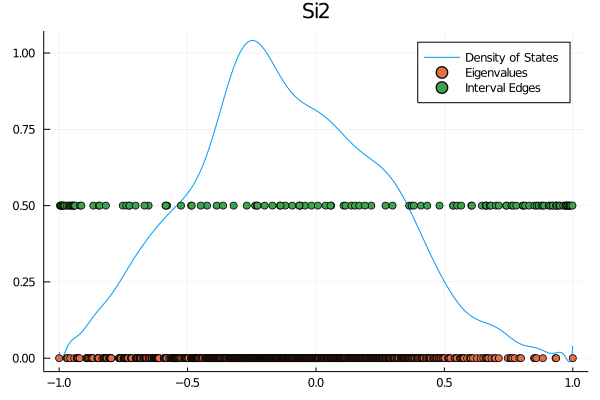

In [8]:
p = SpectrumSlicingTestSuite.kpm(Diagonal(W),V,25);

x = range(-1, 1, length=1001);
plot( x, p.(x) , label="Density of States", title="Si2")
scatter!(W, 0.0 .*ones(size(W)...), label="Eigenvalues")
intervalEdge = union( map( x-> x[1], intvls), map( x-> x[2], intvls))
scatter!(intervalEdge, 0.5.*ones(size(intervalEdge)...), label="Interval Edges")

## Performance of Rational Filters in FEAST
Get the FEAST convergence ratios for these intervals

In [9]:
convergenceRatioGauss = SpectrumSlicingTestSuite.convergenceratio(zGauss,aGauss,W,intvls,nexPercentage);
convergenceRatioSLiSe = SpectrumSlicingTestSuite.convergenceratio(zSLiSe,aSLiSe,W,intvls,nexPercentage);

Plot the convergence rates as a performance profile, see [here](https://link.springer.com/article/10.1007%2Fs101070100263) and [here](https://dl.acm.org/citation.cfm?id=2950048)

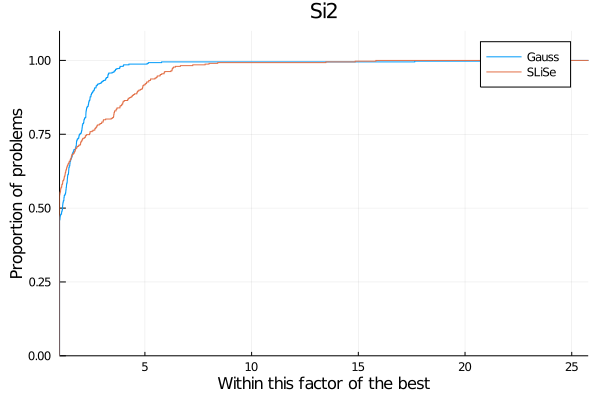

In [10]:
BenchmarkProfiles.performance_profile(
    BenchmarkProfiles.PlotsBackend(),
    [convergenceRatioGauss convergenceRatioSLiSe],
    ["Gauss","SLiSe"],
    logscale=false, title="Si2")

## Filter performance for additional matrices
In order to obtain a more well-rounded comparison of the two filters, we apply the above process to multiple matrices from the [SuiteSparse Matrix Collection](https://sparse.tamu.edu/)

In [11]:
function getRatios( s, nexPercentage = 0.5, nvec = 10 )
    try
        # MatrixDepot.update()
        MatrixDepot.matrixdepot(s)
    catch
    end

    B = MatrixDepot.matrixdepot(s);
    n = size(B)[1];
    V = (randn(n,nvec) + randn(n,nvec) * 1im) / sqrt(2);
    intvls,W = SpectrumSlicingTestSuite.testIntervals(B,V;l=0.02, u=0.04);
    convergenceRatioGauss = SpectrumSlicingTestSuite.convergenceratio(zGauss,aGauss,W,intvls,nexPercentage);
    convergenceRatioSLiSe = SpectrumSlicingTestSuite.convergenceratio(zSLiSe,aSLiSe,W,intvls,nexPercentage);
    (convergenceRatioGauss,convergenceRatioSLiSe)
end

problems1 = [
    "PARSEC/Na5"
    "PARSEC/SiH4"
    "PARSEC/SiNa"
    "PARSEC/benzene"
]

ratios1 = map(getRatios,problems1);

Shown below is a plot generated from four matrices from the PARSEC group. These matrices are obtained from electronic structure calculations. Note that the plots looks very similar to the performance profile above.

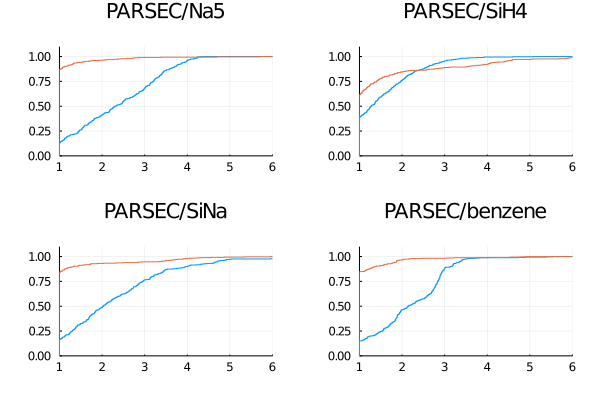

In [12]:
plots = map(ratios1) do x
    BenchmarkProfiles.performance_profile(
        BenchmarkProfiles.PlotsBackend(),
        [x[1] x[2]],
        ["",""],
        logscale=false)
end

plot(plots..., 
    legend=false, 
    xlabel="", 
    ylabel="", 
    margin=5mm,
    xlims = (1,6),
    title=reshape(problems1,1,length(problems1))
)

Now we present performance profiles for four matrices from the VDOL group, which are optimal control problems. Here the `SLiSe` filter performs significantly better than the Gauss filter.

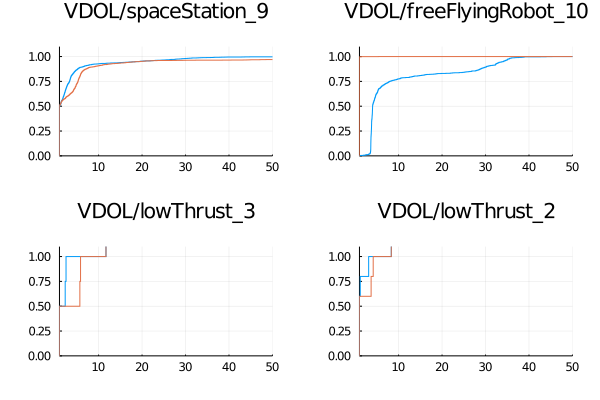

In [13]:
problems2 = [
    "VDOL/spaceStation_9"
    "VDOL/freeFlyingRobot_10"
    "VDOL/lowThrust_3"
    "VDOL/lowThrust_2"
]

ratios2 = map(getRatios,problems2)
plots = map(ratios2) do x
    BenchmarkProfiles.performance_profile(
        BenchmarkProfiles.PlotsBackend(),
        [x[1] x[2]],
        ["",""],
        logscale=false)
end

Plots.plot(plots..., 
    legend=false,
    xlims = (1,50),
    xlabel="",
    ylabel="",
    margin=5mm,
    title=reshape(problems2,1,length(problems2))
)

We can combine the data from all nine matrices into a single performance profile:

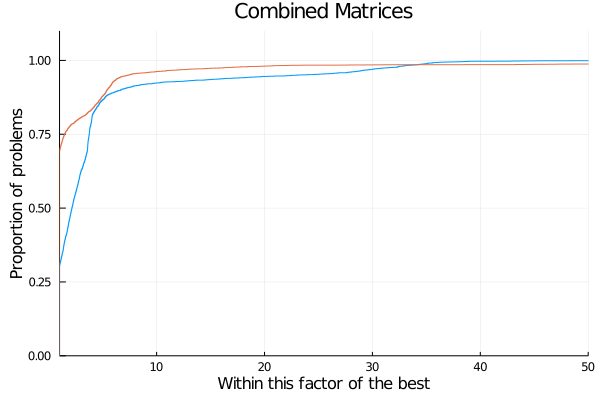

In [14]:
ratioGauss = convergenceRatioGauss;
ratioSLiSe = convergenceRatioSLiSe;

for x in ratios1
   append!(ratioGauss,x[1]) 
   append!(ratioSLiSe,x[2]) 
end
for x in ratios2
   append!(ratioGauss,x[1]) 
   append!(ratioSLiSe,x[2]) 
end

p = BenchmarkProfiles.performance_profile(
        BenchmarkProfiles.PlotsBackend(),
        [ratioGauss ratioSLiSe],
        ["",""],
        logscale=false);

Plots.plot(p, xlims = (1,50), title="Combined Matrices")